In [2]:
# default_exp streetlight_analysis

In [13]:
#export
import numpy as np
import os
import cv2
from matplotlib import colors
from matplotlib import pyplot as plt
from skimage import measure
from tqdm import tqdm
from matplotlib.colors import to_hex

# Streetlight analysis

> The functions of this module allows one to find the the streetlight in an image and extract the color of the streetlight.

In [14]:
#export
def imread(name):
    "Reads the image from a path and outputs an RGB array"
    im = cv2.imread(name) #open CV output a BGR format 
    im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
    return im

def show_im(im,ax, title='image', axes=False, cmap=None):
    "Helper for doing imshow without axis"
    image = ax.imshow(im, cmap=cmap)
    ax.set_title(title)
    if axes==False: ax.set_axis_off() 
    return image
    
def plot_color_points(ax, color_small, color_big, label_small, label_big):
    "Helper for plotting points in final figure"
    ax.scatter(1, 1, s=200, facecolor =color_small)
    ax.scatter(2, 1, s=200, facecolor =color_big)
    ax.set_xlim(0,3)
    ax.set_title(f'Color(s/b):{label_small}/{label_big}');ax.set_axis_off() 


In [15]:
#export
def image_transformation(path, thresh=0.9, gray_min = 20):
    "Opens an image, transforms it into grayscale, and returns a blurred image and an image with only the brightest points"
    gray = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    blurred = cv2.GaussianBlur(gray, ksize=(11,11), sigmaX=0)
    maxi = max(gray_min, np.amax(blurred))
    thresh = cv2.threshold(blurred, int(maxi*thresh), 255, cv2.THRESH_BINARY)[1]
    thresh = cv2.erode(thresh, None, iterations=2)
    thresh = cv2.dilate(thresh, None, iterations=4)
    return blurred, thresh

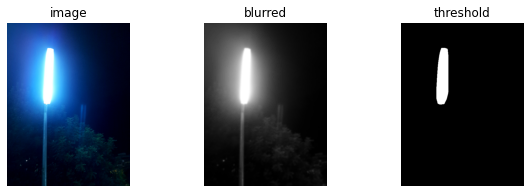

In [16]:
name = 'data/sample_1.png'

im = imread(name) 
blurred, thresh = image_transformation(name)

images = [im, blurred, thresh]
cmaps = [None, 'gray', 'gray']
titles = ['image', 'blurred', 'threshold']
fig, ax = plt.subplots(1,3, figsize=(10,3))

for i, image in enumerate(images):
    show_im(image,ax[i], title=titles[i], cmap=cmaps[i])

In [17]:
#export
def brightest_area(path):
    '''Given the name of image, find the brightest area and returns a 
    mask of it'''    
    # Transform image
    blurred, thresh = image_transformation(path)   
    # Extract blobs
    labels = measure.label(thresh, connectivity=2, background=0)
    numbers = np.unique(labels)
    # Find the most saturated region by means of ratio
    max_pixel, blob_len = [], []
    for i in numbers[1:]:
        blob = blurred[labels == i] 
        max_pixel.append(np.amax(blob))
        blob_len.append(len(blob)) 
    
    #To take into account bad images (with no points above the threshold)
    if len(max_pixel) < 1:
        return False
    else:
        maxi = max(max_pixel)
        length = -1
        for i,val_max in enumerate(max_pixel):
            if val_max == maxi and blob_len[i]>length:
                ind_sat = i + 1
                length = blob_len[i]
        return labels==ind_sat

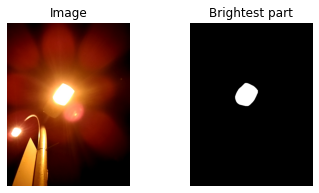

In [18]:
name = 'data/sample_2.png'

im = imread(name)

im_bright = brightest_area(name)

fig, ax = plt.subplots(1,2, figsize=(6,3))

show_im(im,ax[0], title='Image')
show_im(im_bright,ax[1], title='Brightest part', cmap='gray') 

In [19]:
#export
def crop_to_mask(name, ratio_sb = 2):
    '''Given the name of an image, crops its brightest spot. The funcion
    creates two images: 
        - One that fits exactly the brightest spot
        - One that is ratio_sb bigger'''
    
    # Transform image and get brightest spot
    blurred, thresh = image_transformation(name)  
    mask = brightest_area(name) 
    if isinstance(mask, bool): # To take into account bad images
        return False, False, False
    # get sizes and position of extrems
    imsize=np.array([thresh.shape[0]-1, thresh.shape[1]-1])
    i, j = np.where(mask)
    xmin, xmax = np.amin(i), np.amax(i)
    ymin, ymax = np.amin(j), np.amax(j)
    # get size for big image 
    dx2, dy2 = int((xmax-xmin)/ratio_sb), int((ymax-ymin)/ratio_sb)
    # create meshgrid for big and small images
    bb_small = np.meshgrid(np.arange(xmin, xmax),
                            np.arange(ymin, ymax),
                            indexing='ij')
    bb_big = np.meshgrid(np.arange(max(0,xmin- dx2),min(imsize[0],xmax+dx2)),
                            np.arange(max(0,ymin-dy2), min(imsize[1],ymax+dy2)),
                            indexing='ij')

    bb_small, bb_big = tuple(bb_small), tuple(bb_big)
    # create new mask in 3 channels
    mask_3channel = np.repeat(mask[:,:,np.newaxis],3,axis=2)
    
    return bb_small, bb_big, mask_3channel

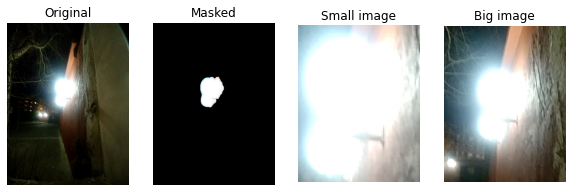

In [20]:
name = 'data/sample_4.png'

im = imread(name)
bb_small, bb_big, mask_3channel = crop_to_mask(name, ratio_sb=2)

fig, ax = plt.subplots(1,4, figsize = (10,10))

show_im(im,ax[0], title='Original')
show_im(im*mask_3channel,ax[1], title='Masked')
show_im(im[bb_small],ax[2], title='Small image')
show_im(im[bb_big],ax[3], title='Big image')

In [21]:
#export
def non_saturated_mask(im, saturation_value = 254, new_value = 0):
    "Creates a mask that selects only the non-saturated points above a saturation value"
    masked = im.copy()
    masked[masked > saturation_value] = False
    return masked

def non_saturated_mask_allchannels(im, saturation_value = 254, new_value = 0):
    "Creates a mask that selects only the non-saturated points above a saturation value for the 3 channels"
    masked = im.copy()
    r, c, _ = np.where(masked>saturation_value)
    masked[r,c,:] = new_value
    return masked

def mean_color(im):
    ''' Finds the average color of the non-zero points of the image '''
    R, G, B = im[:,:,0], im[:,:,1], im[:,:,2]
    return np.array([np.mean(R[R>0])/255, np.mean(G[G>0])/255, np.mean(B[B>0])/255])

def color_label(color):
    ''' Finds the red and blue regions from an array of RGB colors '''
    h = colors.rgb_to_hsv(color)[:,0]
    v = colors.rgb_to_hsv(color)[:,2]
    cl = np.array(h.size*['k'])
    cl[h < 0.2] = 'r'
    cl[np.logical_and(h > 0.5, h < 0.7)] = 'b'
    return cl

In [25]:
#export
def image_analysis(name, path=None, save_path=None, format_file='pdf', dpi=None,ratio_sb=2, save = False):
    "Creates an image with the original image, the small box, the big box and the colors and labels of these boxes"
    if path == None: path = ''
    if save_path == None: save_path = ''
    im = imread(path + name)
    filename, file_extension = os.path.splitext(name)

    bb_small, bb_big, mask_3channel = crop_to_mask(path + name, ratio_sb=ratio_sb)
    warning = 0
    if isinstance(bb_small, bool): # Takes into acount not finding blobs (i.e. corrupt images)       
        grid = plt.GridSpec(3, 4, wspace=0.4, hspace=0.3)
        
        ax = [plt.subplot(grid[0:3, 0:2]), plt.subplot(grid[0, 2]),plt.subplot(grid[1, 2]), plt.subplot(grid[2, 2])]

        show_im(im,ax[0], title=f'{name}: corrupted')
        show_im(im,ax[1], title='small box')
        show_im(im,ax[2], title='big box')
        plot_color_points(ax[3], 'k' , 'k', 'k', 'k')
        
        if save:
            save_name = save_path+name.replace('.png',f'.{format_file}')
            plt.savefig(save_name)
        color_small, color_big, label_small, label_big = to_hex(np.zeros(3)), to_hex(np.zeros(3)),'k', 'k'
        warning = 1
    else:

        ymin, ymax, xmin, xmax = np.amin(bb_big[0]), np.amax(bb_big[0]), np.amin(bb_big[1]), np.amax(bb_big[1])
        im_box = np.copy(im)
        im_box = cv2.rectangle(im_box,(xmin,ymin),(xmax,ymax),(0,255,0),3)

        grid = plt.GridSpec(3, 4, wspace=0.4, hspace=0.3)

        ax = [plt.subplot(grid[0:3, 0:2]), plt.subplot(grid[0, 2]),plt.subplot(grid[1, 2]), plt.subplot(grid[2, 2])]

        small, big = non_saturated_mask_allchannels(im[bb_small]), non_saturated_mask_allchannels(im[bb_big])
        color_small, color_big = mean_color(small), mean_color(big)
        label_small, label_big = color_label([color_small, color_big])
        color_small, color_big = to_hex(color_small), to_hex(color_big)

        if label_small == label_big:
            title = f'{name}'
        else:
            title = f'{name}: warning'
            warning = 1
        show_im(im_box,ax[0], title= title)
        show_im(im[bb_small],ax[1], title='small box')
        show_im(im[bb_big],ax[2], title='big box')

        plot_color_points(ax[3], color_small, color_big, label_small, label_big)
        
        if save:        
            save_name = save_path+name.replace(file_extension,f'.{format_file}')        
            plt.savefig(save_name,dpi=dpi)
    info_file_name_analysis = name.replace(file_extension,f'.{format_file}')
    prop = ['color_small', 'color_big', 'label_small', 'label_big', 'warning','info_file_name_analysis']
    d = {}
    for var in prop: d[var]=eval(var)
    return d

def image_analysis_df(item, path=None, save_path=None, format_file='pdf', dpi=None,ratio_sb=2):
    "calls image analysis by looking at the name in a df"
    name = item['info_file_name']
    d = image_analysis(name, path=path, save_path=save_path, format_file=format_file, dpi=dpi, ratio_sb=ratio_sb)
    return d

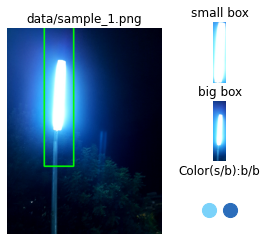

In [26]:
name = 'data/sample_1.png'
dic = image_analysis(name)